<a href="https://colab.research.google.com/github/sdf-jkl/Pitney-Bowes-challenge/blob/main/just_one_customer_from_the_start.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

importing dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')
copied_path = 'drive/MyDrive/train_anonimized.csv'
df = pd.read_csv(copied_path, parse_dates= ['DATE'])
df = df.set_index('DATE')
df.info()

Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25163 entries, 2021-08-30 to 2022-06-30
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   NAICS_DESC       22571 non-null  object
 1   REVENUE          25163 non-null  int64 
 2   anonimized_name  25163 non-null  object
dtypes: int64(1), object(2)
memory usage: 786.3+ KB


In [2]:
df.anonimized_name.value_counts()
print(df.duplicated().sum())
df = df.drop_duplicates(keep = 'first')
print(df.duplicated().sum())


2529
0


In [3]:
df = df.fillna('unknown')
df.info()
df.anonimized_name.value_counts()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22634 entries, 2021-08-30 to 2022-06-30
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   NAICS_DESC       22634 non-null  object
 1   REVENUE          22634 non-null  int64 
 2   anonimized_name  22634 non-null  object
dtypes: int64(1), object(2)
memory usage: 707.3+ KB


Kimberly Pratt INC           1027
Stephen Martin INC            964
Hannah Holland INC            938
Holly Roberts INC             908
Brian Moore INC               728
Renee Fisher INC              717
Brian Miller INC              708
Brian Porter INC              707
Larry Morales INC             703
Jason Brown INC               656
Amy Dunn INC                  640
Jessica Hernandez INC         637
Gary Nguyen INC               616
Matthew Valdez INC            600
Cory Cooper INC               591
Jacob Stein INC               559
Sarah Keith INC               557
Sean Weeks INC                555
Russell Yang INC              546
Jessica Hendricks INC         527
Jeffrey Brown INC             521
Daniel George INC             518
Dean Welch INC                506
Anne Davis INC                467
Nicholas Evans INC            446
Brian Lester INC              434
James Sandoval INC            419
Miss Amanda Harris MD INC     407
Todd Young INC                404
Ruth Hoffman I

Kimberly Pratt INC has biggest amount of values, will work with him

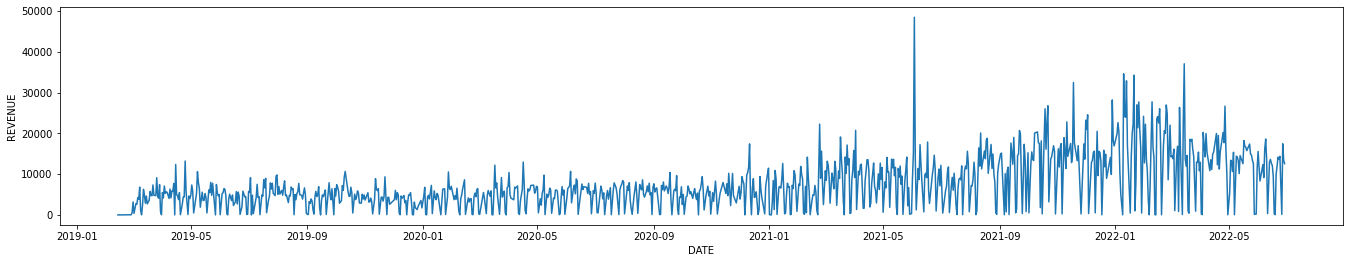

In [4]:
customer = df[df['anonimized_name'] == 'Kimberly Pratt INC']
customer = customer.drop(['NAICS_DESC', 'anonimized_name'], axis = 1)
plt.figure(figsize = (23, 4))
sns.lineplot(x = customer.index, y = customer['REVENUE'])
plt.show()

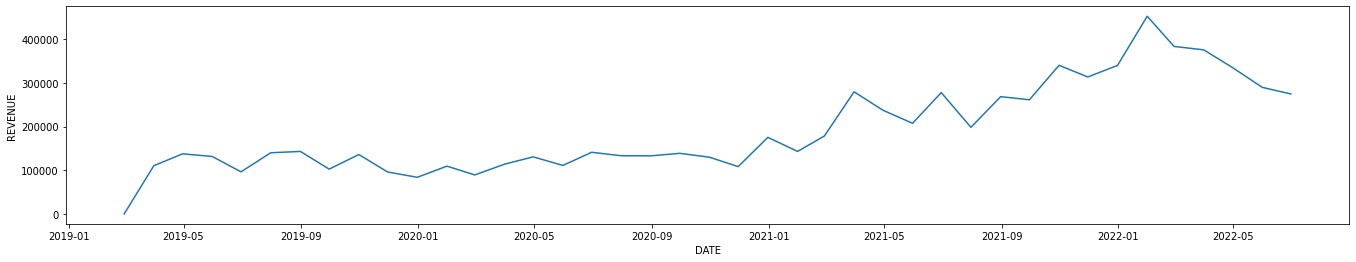

41

In [5]:
customer = customer.resample('M').sum()
plt.figure(figsize = (23, 4))
sns.lineplot(x = customer.index, y = customer['REVENUE'])
plt.show()
len(customer)

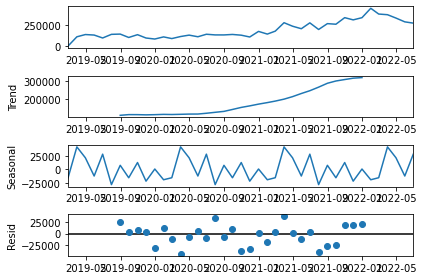

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(customer)
result.plot()
plt.show()

In [7]:
! pip install pmdarima
from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha = .05)
print(adf_test.should_diff(customer))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 50.3 MB/s eta 0:00:00
(0.3200682817523095, True)


Data is stationary

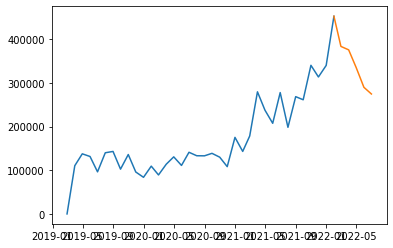

In [8]:
train = customer.iloc[:len(customer)-5]
test = customer.iloc[len(customer)-6:]
plt.plot(train)
plt.plot(test)

In [9]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")
stepwise_fit = auto_arima(train, start_p= 1, start_q= 1, max_p = 10, max_q = 10,
                          start_P = 0, seasonal = True,
                          d = None, D = 0, trace = True,
                          error_action ='ignore',
                          suppress_warnings = True,
                          stepwise = True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=854.092, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=855.084, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=852.577, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=853.865, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=855.733, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=853.388, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=855.246, Time=0.02 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.711 seconds


In [10]:
test

,REVENUE
DATE,
2022-01-31,452134
2022-02-28,383209
2022-03-31,375359
2022-04-30,335005
2022-05-31,289798
2022-06-30,274561


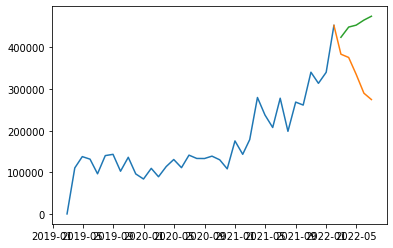

In [11]:
forecast = pd.DataFrame(stepwise_fit.predict(n_periods = 6, x = test), index = test.index)
forecast.columns = ['REVENUE']
plt.plot(train)
plt.plot(test)
plt.plot(forecast)

In [12]:
from sklearn.metrics import mean_absolute_percentage_error as mape
mape(test, forecast)


ValueError: ignored